# Outcomes

The purpose of this section is to understand the effectiveness of our ADS by comparing its performance across sub-populations.  Here, we select one or more fairness or diversity measures (justifying our choice for the measure) and quatify the fairness of this ADS.

In addition, we will attempt to develop additional methods for analyzing ADS performance: think about stability, robustness, performance on difficult or otherwise important examples (in the style of LIME) or any other property that you believe is important to check for this ADS.

In [14]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as mtick
import seaborn as sns
import functools
import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

ads_output = pd.read_csv('../data/ADS_output.csv')
display(ads_output.head())
print(ads_output.shape)

pip install 'aif360[AdversarialDebiasing]'


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,prediction
0,31373,city_159,0.843,Female,Has relevent experience,No Enrollment,Masters,STEM,8,50-99,Pvt Ltd,1,246,0.0,0.0
1,28751,city_103,0.920,Not provided,No relevent experience,Full time course,High School,Unknown,4,0,Unknown,3,75,0.0,1.0
2,2533,city_162,0.767,Male,Has relevent experience,Full time course,Graduate,STEM,4,500-999,Pvt Ltd,1,48,0.0,0.0
3,18712,city_103,0.920,Male,No relevent experience,No Enrollment,Graduate,STEM,2,500-999,Public Sector,1,7,1.0,0.0
4,12900,city_138,0.836,Male,Has relevent experience,No Enrollment,Masters,STEM,20,100-500,Pvt Ltd,1,5,0.0,0.0


(5405, 15)


## Gender


In [5]:
#Get the prediction and the actual test results for comparison.
y_predict = ads_output['prediction']
y_test = ads_output['target']

In [16]:
def insensitive_roc_auc(y_true, y_score):
    #to handle subgroups with only one class.
    if sum(y_true)!=len(y_true) and sum(y_true)!=0:
        return skm.roc_auc_score(y_true, y_score)
    else:
        return np.nan

def samplesize(y_true, y_score):
    return len(y_true)

#Metrics 
metric_fns = {'samplesize': samplesize, 
              'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their label
              'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

grouped_on_gender = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=ads_output['gender'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D95DAB08B0>,
      dtype=object)

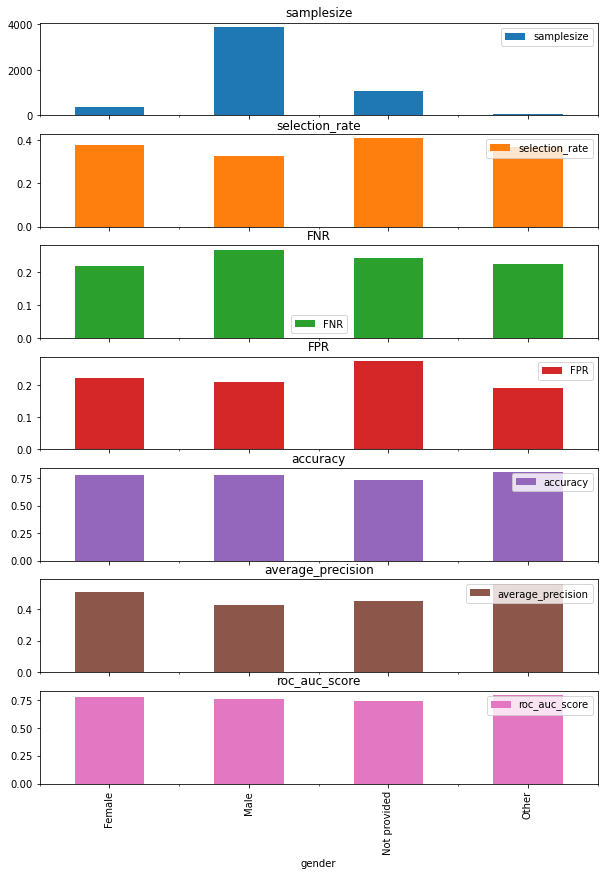

In [18]:
# Plot the metric values
grouped_on_gender.by_group.plot.bar(subplots=True, figsize=(10, 14))

## Education Level

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D95F93FF70>,
      dtype=object)

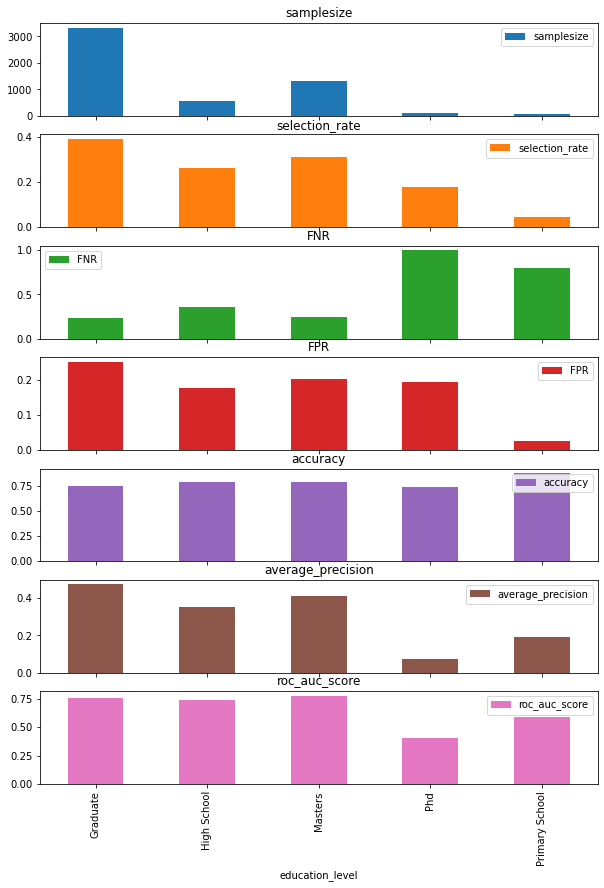

In [20]:
grouped_on_education = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=ads_output['education_level'])
# Plot the metric values
grouped_on_education.by_group.plot.bar(subplots=True, figsize=(10, 14))

## Experience

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D95FD67D60>,
      dtype=object)

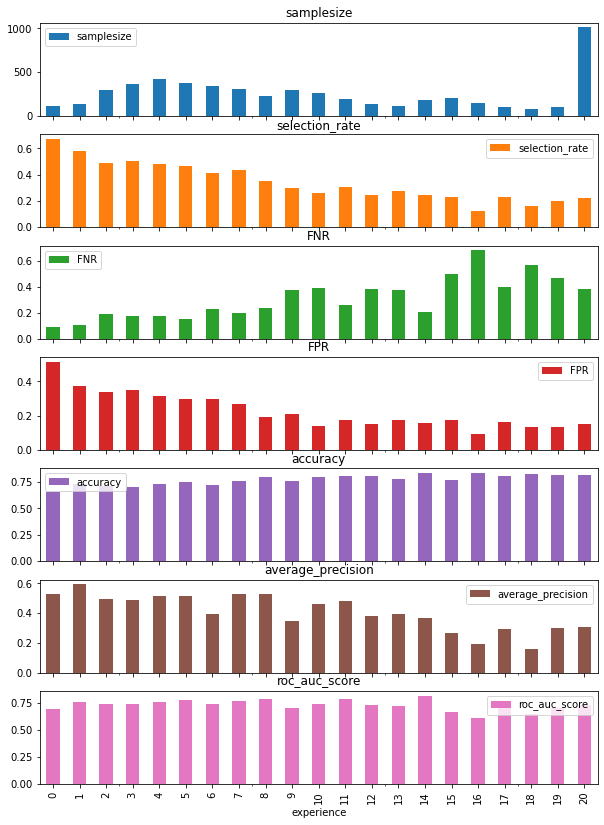

In [21]:
grouped_on_experience = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=ads_output['experience'])
# Plot the metric values
grouped_on_experience.by_group.plot.bar(subplots=True, figsize=(10, 14))

## City Development

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D9617EFA00>,
      dtype=object)

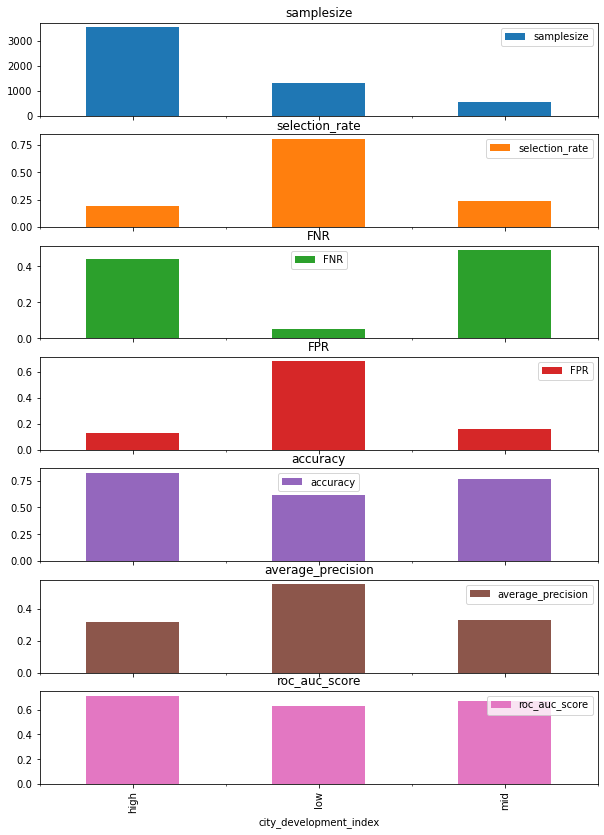

In [24]:
ads_output1 = ads_output.copy()
ads_output1['city_development_index'] = ads_output1['city_development_index'].apply(lambda x:
                                                                'low' if x < 0.75 else 'mid' if x <0.85 else 'high')


grouped_on_city_development = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=ads_output1['city_development_index'])
# Plot the metric values
grouped_on_city_development.by_group.plot.bar(subplots=True, figsize=(10, 14))

## Explaining Models with SHAP
### Use summary_plot to summarize the most important features.